Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

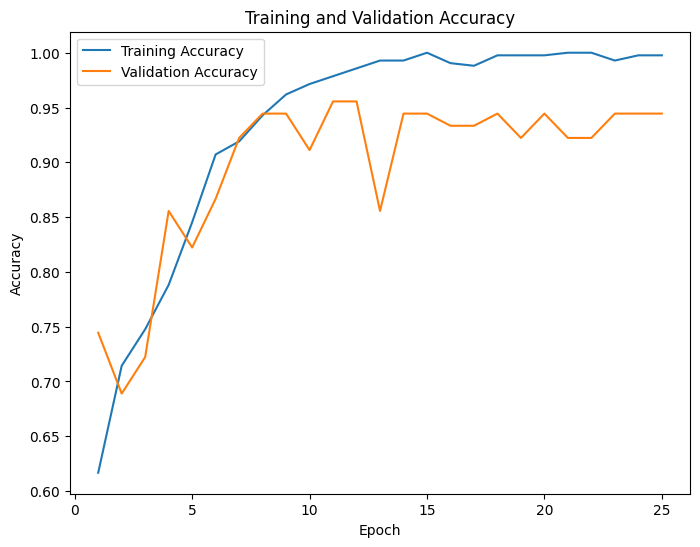

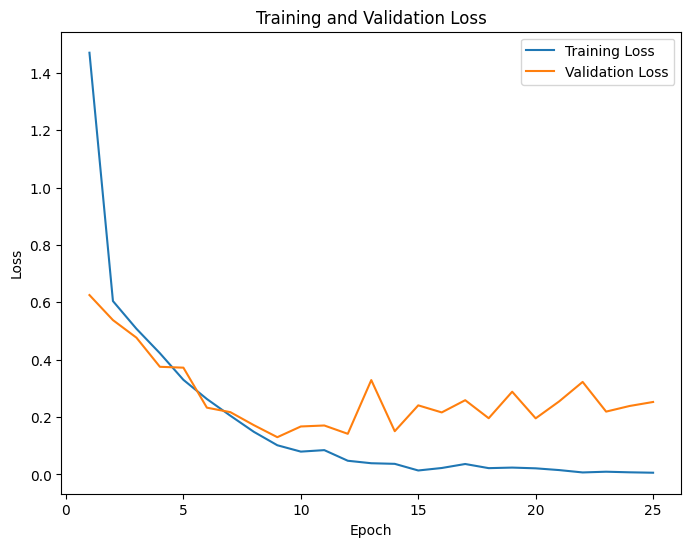

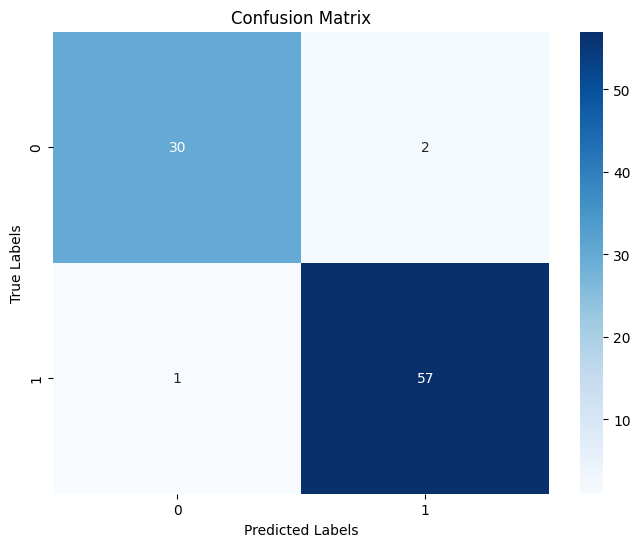

Testing Time: 0.47 seconds
Training Accuracy: 0.9976190328598022
Validation Accuracy: 0.9444444179534912
Test Accuracy: 0.9666666666666667
Overall Accuracy: 0.9666666666666667
Precision: 0.9661016949152542
Recall: 0.9827586206896551
F1-score: 0.9743589743589743
Confusion Matrix:
[[30  2]
 [ 1 57]]
True Positives: 30
False Positives: 2
True Negatives: 57
False Negatives: 1


In [2]:
#importing libraries
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
import time

#defining preprocess function
def preprocess_image(image, target_size=(256, 256)):
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # Normalize the pixel values to [0, 1]
    image = image.astype(np.float32) / 255.0
    return image

#dataset loading and labeling
dataset_dir = r"/content/drive/MyDrive/f600"

images = []
labels = []

image_filenames = os.listdir(dataset_dir)
for filename in image_filenames:
    image_path = os.path.join(dataset_dir, filename)
    image = cv2.imread(image_path)
    if image is not None:
        images.append(preprocess_image(image))

        # Assuming the ground truth label is part of the image filename
        label = 1 if 'scale' in filename else 0
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

#split
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#defining cnn model
def create_copy_move_detection_model(input_shape=(256, 256, 3), num_classes=2):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output to feed into dense layers
    model.add(Flatten())

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Apply dropout before the final dense layer

    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create and compile the model
input_shape = (256, 256, 3)
num_classes = 2
model = create_copy_move_detection_model(input_shape, num_classes)

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

#training the model
start_time = time.time()
epochs = 25
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
end_time = time.time()

#Predict and Evaluate on Test Set
start_test_time = time.time()
y_pred = model.predict(X_test)
end_test_time = time.time()

testing_time_seconds = end_test_time - start_test_time

y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
epochs = np.arange(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Print and plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Extract TP, FP, TN, FN from the confusion matrix
tp, fp, fn, tn = conf_matrix.ravel()

# Calculate overall accuracy
overall_accuracy = (tp + tn) / (tp + fp + tn + fn)

# Print results
print("Testing Time: {:.2f} seconds".format(testing_time_seconds))
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])
print("Test Accuracy:", accuracy)
print("Overall Accuracy:", overall_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)
print("True Positives:", tp)
print("False Positives:", fp)
print("True Negatives:", tn)
print("False Negatives:", fn)


In [3]:
model.save("final_f600_cnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
